# <center>__Assignment 5__</center>

In [1]:
"""import the necessary packages"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

## Question 1

Use the entire health data provided on canvas for this question. Here are the first few rows of the data.

![Healthcare Data](healthcare_data.png)

The variables are described as follows:

age  =  Age in years divided by 100.

income = Annual income in tens of thousands of dollars.

illness = Number of illnesses in past 2 weeks.

reduced = Number of days of reduced activity in past 2 weeks due to illness or injury.

health = General health questionnaire score using Goldberg's method. Note that higher health scores indicate worse health condition. 

Use the age, income, illness and reduced variables as input variables and use the health variable as an output variable. You will find the parameters or coefficients (intercept and slopes) of a regression equation that models the relationship between the input and output variables. First use the StandardScaler() in sklearn to standardize the input data before you run your algorithm or fit your model.

In [2]:
"""load the healthcare data"""

healthcare = pd.read_csv('Health_Data.csv')
healthcare.head()

,age,income,illness,reduced,health
0,0.19,0.55,1,4,1
1,0.19,0.45,1,2,1
2,0.19,0.90,3,0,0
3,0.19,0.15,1,0,0
4,0.19,0.45,2,5,1


In [3]:
"""apply StandardScaler to the data"""

# instantiate transformer
sc = StandardScaler()
# fit_transform the input features
healthcare.iloc[:, :-1] = sc.fit_transform(healthcare.iloc[:, :-1])

## a)	Implement batch gradient descent from scratch to find the regression parameters as in the pseudo code below:

![Batch Gradient Descent](batch_gradient_descent.png)

In [4]:
"""define batch gradient descent function"""

def batch_gradient_descent(data, iterations, alpha):

    # initialize beta for intercept and each feature
    b_0 = 0
    b_1 = 0
    b_2 = 0
    b_3 = 0
    b_4 = 0
    # convert input features to numpy array
    data = data.to_numpy()
    # get number of observations
    n = len(data)
    # get feature vectors
    x_1 = data[:, 0:1].flatten()
    x_2 = data[:, 1:2].flatten()
    x_3 = data[:, 2:3].flatten()
    x_4 = data[:, 3:4].flatten()
    # get target vectors
    y = data[:, 4:5].flatten()
    # iterate over features, descend to optimal parameters for beta
    for i in range(iterations):
        # update predicted y
        predicted_y = b_0 + (b_1*x_1) + (b_2*x_2) + (b_3*x_3) + (b_4*x_4)
        # compute errors, gradient descent rule eliminates need to square
        errors = y - predicted_y
        # update intercept
        b_0 = b_0 + (alpha * (1/n) * np.sum(errors))
        # update feature wieghts
        b_1 = b_1 + (alpha * (1/n) * np.sum(errors*x_1))
        b_2 = b_2 + (alpha * (1/n) * np.sum(errors*x_2))
        b_3 = b_3 + (alpha * (1/n) * np.sum(errors*x_3))
        b_4 = b_4 + (alpha * (1/n) * np.sum(errors*x_4))
    
    # return intercept and regression coefficients
    return b_0, b_1, b_2, b_3, b_4

# apply function to healthcare data
batch_gradient_descent(healthcare, 1000, 0.01)

(1.217481156240388,
 -0.17253212081475547,
 -0.10527913575641316,
 0.6847604319993603,
 0.4572023400379416)

### b)	Now, use a vectorized or matrix implementation instead of having a line of code for each x or b. That mean, you can a create a vector of b’s and a feature matrix, X where you have an additional column for x0 whose values are 1’s. x0 corresponds to b0. You can still implement it as described in the code above. See the “Gradient Descent Vector/Matrix Implementation” document on canvas for additional tips


In [5]:
"""define vectorized batch gradient descent function"""

def vectorized_batch_gradient_descent(data, iterations, alpha):

    # initialize column vector of actual y values
    y = data.to_numpy()[:, 4:5].flatten()
    # create a design matrix of input features, convert to arrray
    X = dmatrix("age+income+illness+reduced", data)[:]
    # initialize column vector of beta values
    # shape determined by formula y_hat=b_row*X.T
    betas = np.zeros((1,5))
    # get number of observations
    n = len(data)
    # iterate over features, descend to optimal parameters for beta
    for i in range(iterations):
        # update predicted y
        predicted_y = np.matmul(betas, X.T)
        # compute errors, gradient descent rule eliminates need to square
        errors = y - predicted_y
        betas = betas + np.sum(errors.T*X, axis=0)*(1/n)*alpha

    # return intercept and regression coefficients
    return betas

# apply function to healthcare data
vectorized_batch_gradient_descent(healthcare, 1000, 0.01)

array([[ 1.21748116, -0.17253212, -0.10527914,  0.68476043,  0.45720234]])

The parameters retrned by the vectorized_batch_gradient_descent function are approximately the same as those returned by the batch_gradient_descent_function.

### c)	Use the scikit-learn package to implement the stochastic gradient descent to find the parameters of the regression equation. See the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor 

In [6]:
"""implement SGDRegressor sklearn, get estimated params"""

# intatiate regressor and fit to healthcare data
sgdr = SGDRegressor(max_iter=1000, alpha=0.01)
sgdr.fit(healthcare.iloc[:, :-1], healthcare.iloc[:, -1:].to_numpy().flatten())
# print estimated intercept
print(sgdr.intercept_)
# print estimated coefficients
print(sgdr.coef_)

[1.27579434]
[-0.18806631 -0.08193838  0.67467105  0.4707095 ]


Are you results in a) and b) and c) similar? The results don’t have to be exact but should be close for most of the betta values.

The coefficient weights estimated by the batch_gradient_descent and vectorized_batch_gradient_descent functions are similar to those produced by the sklearn SGDRegressor estimator.

## Question 2

You will implement a multiple regression from a statistical perspective to explore the relationship between the input variables and the output variable. You will use the health data again.  

### a)	Use the statsmodels package (https://www.statsmodels.org/stable/regression.html#examples) to implement a multiple linear regression using the entire health data to get a more detailed regression summary.

Below is some pseudo code for implementation, see the documentation for details. 
import numpy as np
import statsmodels.api as sm

feature_matrix = sm.add_constant(X_data, prepend=False)

\# Fit and summarize OLS model

model = sm.OLS(y_data, feature_matrix)

res = model.fit()

print(res.summary())

In [7]:
"""
instantiate and fit statsmodels OLS regression model
print models summary
"""

# create the feature matrix (add_constant adds column of ones to input)
feature_matrix = sm.add_constant(healthcare.iloc[:, :-1])
# fit and summarize the model
ols_model = sm.OLS(healthcare.iloc[:, -1:], feature_matrix)
residuals = ols_model.fit()
# print the results
print(residuals.summary())

                            OLS Regression Results                            
Dep. Variable:                 health   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     282.9
Date:                Sun, 07 Aug 2022   Prob (F-statistic):          2.35e-220
Time:                        19:32:41   Log-Likelihood:                -10762.
No. Observations:                5190   AIC:                         2.153e+04
Df Residuals:                    5185   BIC:                         2.157e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2175      0.027     45.558      0.0

b)	Does the model fit the data overall? That is, do all the x’s overall explain a good amount of variance in health outcome? Use information from your results to support your answer.

Analyzing the model summary shows that further exploratory analysis of the data is needed. T-test results show that each of the inputs individually contribute significantly to explaining the variance in the target. Prob (F-statistic) results show that the linear combination of input features significantly explain the relationship between input features and the output. That being said, both the R-squared and Adjusted R-squared values for the model are quite low. What's most concerning is the Ominibus and Prob (Omnibus) values in the summary. A Prob (Omnibus) of 0.000 indicates there is an approximately 0% chance that residual errors are normally distributed.

### c)	Do age, income, illness and reduced variables individually  significantly predict health score? Use information from your summary of the regression results to support your answer.

Yes, each of the input features are individually significant in predicting health score. This can be determined by examining the T-test results in the model summary. The p-value for each input feature is far below an alpha of 0.05. The generally accepted standard for significance.

### d)	Which variable is the best predictor of health score? Why?

I would consider the "illness" variable to be the best predictor of health score. The coefficient estimate for the "illness" variable is higher than that of it's counterparts and the standard error of the coefficient is low. These two factors lead to a resonably large T-test result and show that the variable contributes most significantly to the model.

Note: I did not consider the constant for this question.

### e)	Extract the residuals of the model and test the assumptions normality and homogeneity of variance for the regression model. Are the assumptions met? Use reg.resid syntax to extract the residuals.

In [8]:
"""extract the model residuals and fitted values"""

ols_res_vals = residuals.resid
ols_fitted_vals = residuals.fittedvalues

In [9]:
"""perform a statistical test (Kolmogorov-Smironov) to explore normailty of residuals"""

stats.kstest(ols_res_vals, 'norm')

KstestResult(statistic=0.23189751504868245, pvalue=6.871426514716704e-246)

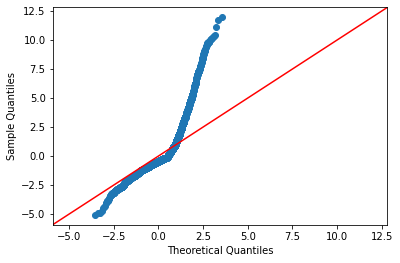

In [10]:
"""perfom a visual test (qq-plot) to explore normality of residuals"""

fig = sm.qqplot(ols_res_vals, line='45')
plt.show()

Results of the Kolmogorov-Smironov test and visual assessment using a qq-plot both confirm the residuals are not normally distributed.

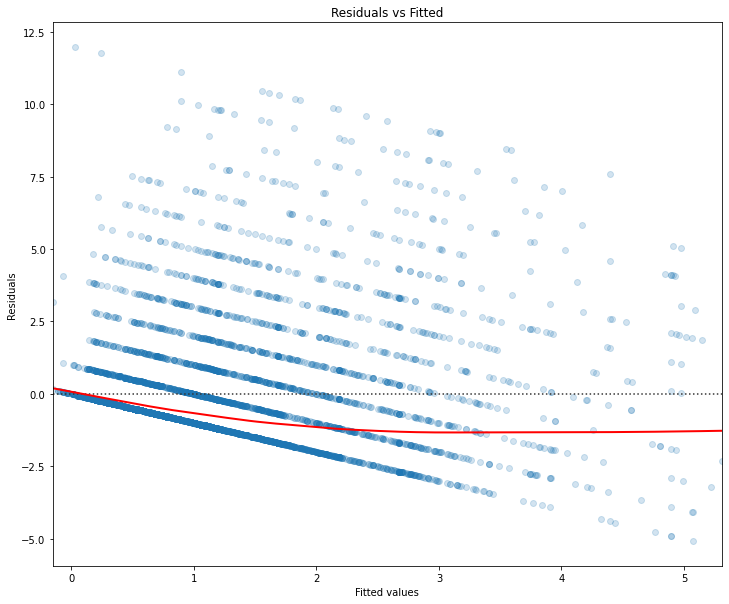

In [11]:
"""perform visual assessmnet (fitted vs residuals plot) to assess equality of variance"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.residplot(x=ols_fitted_vals, y=ols_res_vals,
                          lowess=True,
                          scatter_kws={'alpha': 0.2},
                          line_kws={'color': 'red', 'lw': 2, 'alpha': 1.0})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');


The shape of the fitted vs residuals plot above confirms heteroskedasticity of residuals. Variance is not equal acros errors.

### f)	To further verify the normality assumption, create a histogram for the residuals. Does the histogram look like a normal distribution? 

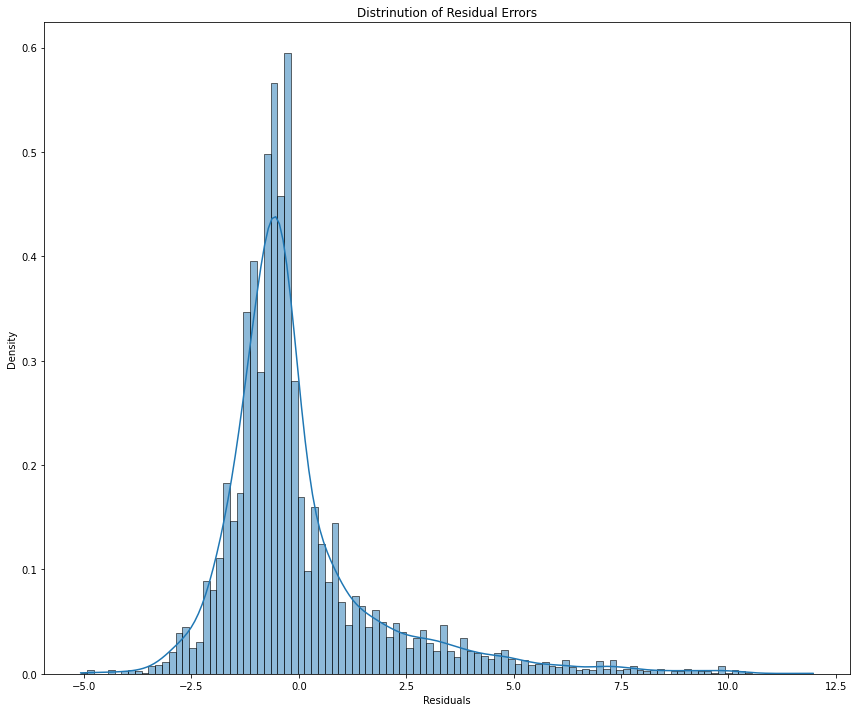

In [14]:
"""create a histogram of the residuals"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.histplot(x=ols_res_vals, stat='density', kde=True)
plt.title('Distrinution of Residual Errors')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

The residuals do not appear to be normally distributed. The distribution is right-skewed, showing the presence of outliers in the data.

### g)	Test the linearity assumption by creating separate scatter plots for each input variable versus output variable. According to your plots, are the linearity assumptions met?

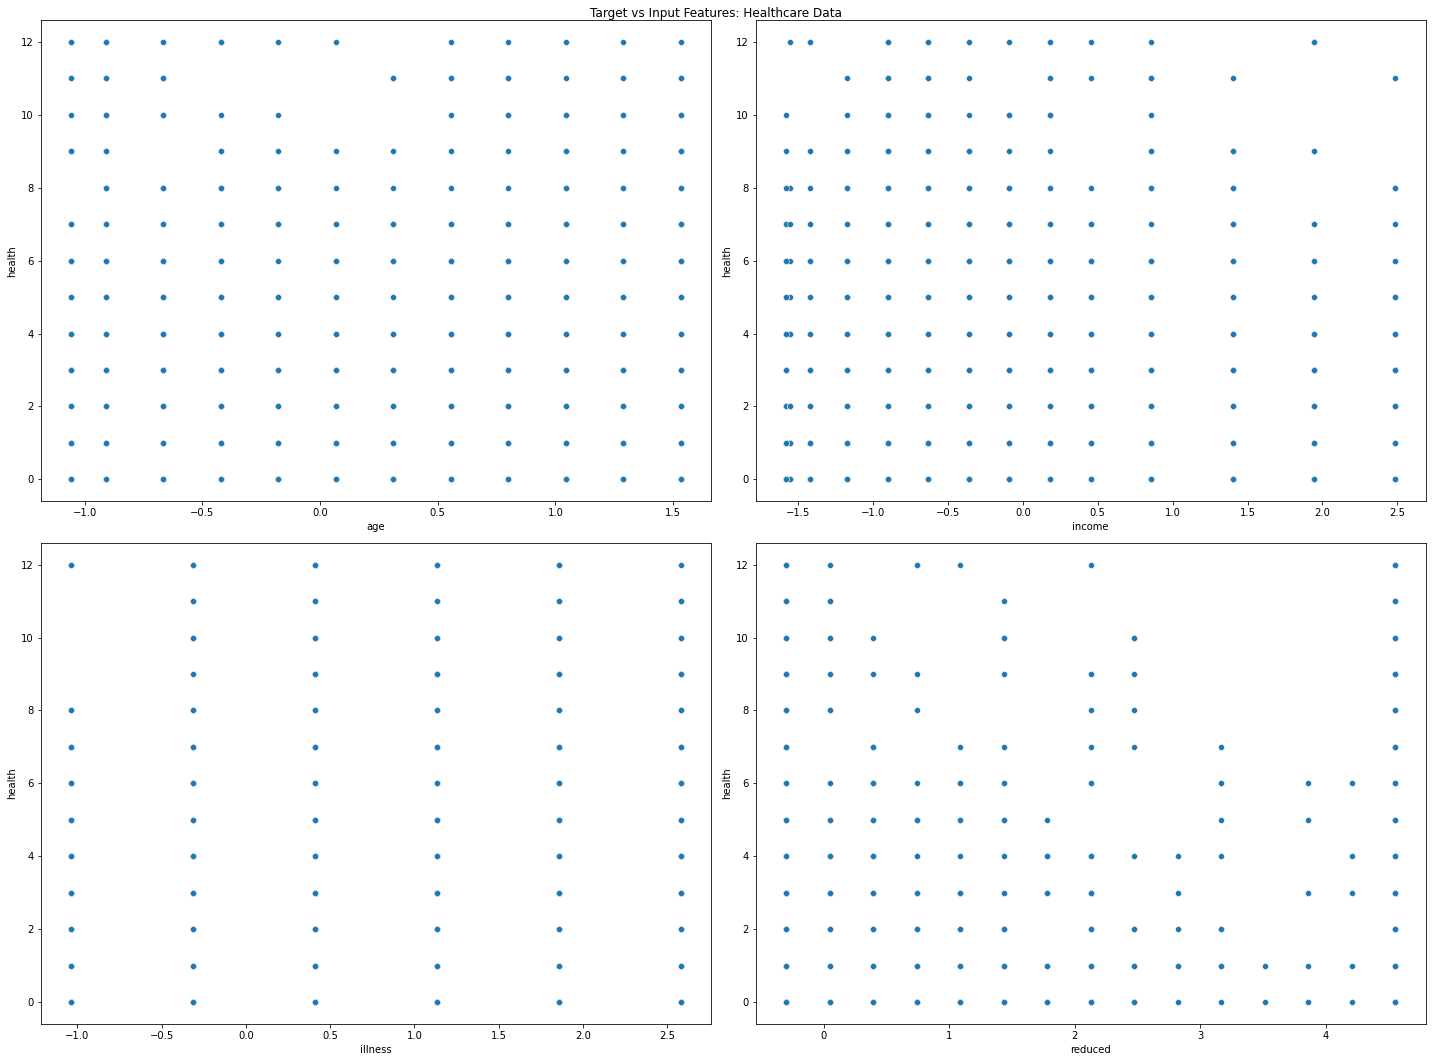

In [15]:
"""create scatter plots of input features vs target"""

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
sns.scatterplot(data=healthcare, x='age', y='health', ax=axs[0, 0])
sns.scatterplot(data=healthcare, x='income', y='health', ax=axs[0, 1])
sns.scatterplot(data=healthcare, x='illness', y='health', ax=axs[1, 0])
sns.scatterplot(data=healthcare, x='reduced', y='health', ax=axs[1, 1])
fig.suptitle('Target vs Input Features: Healthcare Data')
plt.tight_layout()

Examining the scatterplots of inputs vs target it does not appear that a linear relationship exists between any of the input features in the data and the target output.

### h)	Extract the predicted output values from the model, then create a scatter plot of the predicted output versus actual output (from the data provided). This plot is also used to evaluate the accuracy of the model. According to the plot, is your model good for predicting health scores? Use the reg.predict() method to extract the predicted values.

Text(0.5, 1.0, 'Predicted vs Actual Values: Healthcare Data')

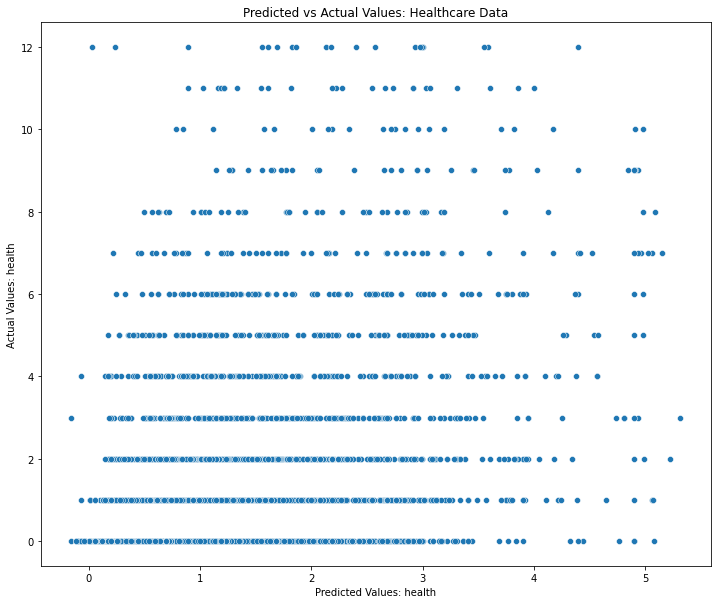

In [16]:
"""create a scatterplot of predicted output vs actual values"""

# extract predictions from the model
predicted = residuals.predict()
# get actual values from the dataset
actual = healthcare.iloc[:, -1:].to_numpy().ravel()
# create sns scatterplot
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x=predicted, y=actual)
plt.xlabel('Predicted Values: health')
plt.ylabel('Actual Values: health')
plt.title('Predicted vs Actual Values: Healthcare Data')

Examing the scatterplot of predicted vs actual values produced by the regression model it's clear that the model was not effective in predicting health scores.

### i)	Check for multi-collinearity by generating a covariance matrix for the input data . You can use the .cov() method of pandas (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html). Do you think there is multicollinearity among the input variables?

In [17]:
"""generate the covariance matrix using pandas built-in function"""

healthcare.iloc[:, :-1].cov()

,age,income,illness,reduced
age,1.000193,-0.271126,0.205023,0.094763
income,-0.271126,1.000193,-0.148840,-0.047554
illness,0.205023,-0.148840,1.000193,0.218158
reduced,0.094763,-0.047554,0.218158,1.000193


The covariance matrix does not show any issues related to multi-collinearity between input features. Covariance values around (+-).90 is an indication of multi-collinearity in the data. None of the values in the above covariance matrix approach this threshhold.

## Question 3

Find your own dataset from an online source with at least 3 input variables. Here is a suggested source of data but you don’t have to use it: https://vincentarelbundock.github.io/Rdatasets/articles/data.html.  There should be one output variable of interest in the data. All the data used for analysis should be continuous. Clean the data as you find necessary, standardize the data and split it into training and test data using an appropriate split ratio. 

### <center>Taiwanese Real Estate Valuation using Regression Techniques</center>

Data: The "Real estate valuation dataset" describes house price per unit area of homes in the Taiwanese city of Taipei. A brief definition of input features and the target are given below:

- X2=the house age (unit: year)
- X3=the distance to the nearest MRT station (unit: meter)
- X4=the number of convenience stores in the living circle on foot (integer)
- Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

This dataset is available for download from the UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

In [19]:
"load the data"

real_estate = pd.read_excel('Real estate valuation data set.xlsx', usecols=['X2 house age', 'X3 distance to the nearest MRT station',
              'X4 number of convenience stores', 'Y house price of unit area'])
real_estate.head()

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,Y house price of unit area
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


In [20]:
"""clean column names"""

real_estate.columns = real_estate.columns.str.lower()
real_estate.columns = real_estate.columns.str.replace(' ', '_', regex=False)
real_estate.columns

Index(['x2_house_age', 'x3_distance_to_the_nearest_mrt_station',
       'x4_number_of_convenience_stores', 'y_house_price_of_unit_area'],
      dtype='object')

In [21]:
"""check for missing data"""

real_estate.isnull().sum()

x2_house_age                              0
x3_distance_to_the_nearest_mrt_station    0
x4_number_of_convenience_stores           0
y_house_price_of_unit_area                0
dtype: int64

In [22]:
"""print summary statistics"""

real_estate.agg(func=['min', 'median', 'mean', 'max', 'var', 'std', 'skew', 'kurtosis'])

,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,y_house_price_of_unit_area
min,0.000000,2.338284e+01,0.000000,7.600000
median,16.100000,4.922313e+02,4.000000,38.450000
mean,17.712560,1.083886e+03,4.094203,37.980193
max,43.800000,6.488021e+03,10.000000,117.500000
var,129.788704,1.592921e+06,8.676334,185.136507
std,11.392485,1.262110e+03,2.945562,13.606488
skew,0.382926,1.888757e+00,0.154607,0.599853
kurtosis,-0.877120,3.207868e+00,-1.065751,2.179097


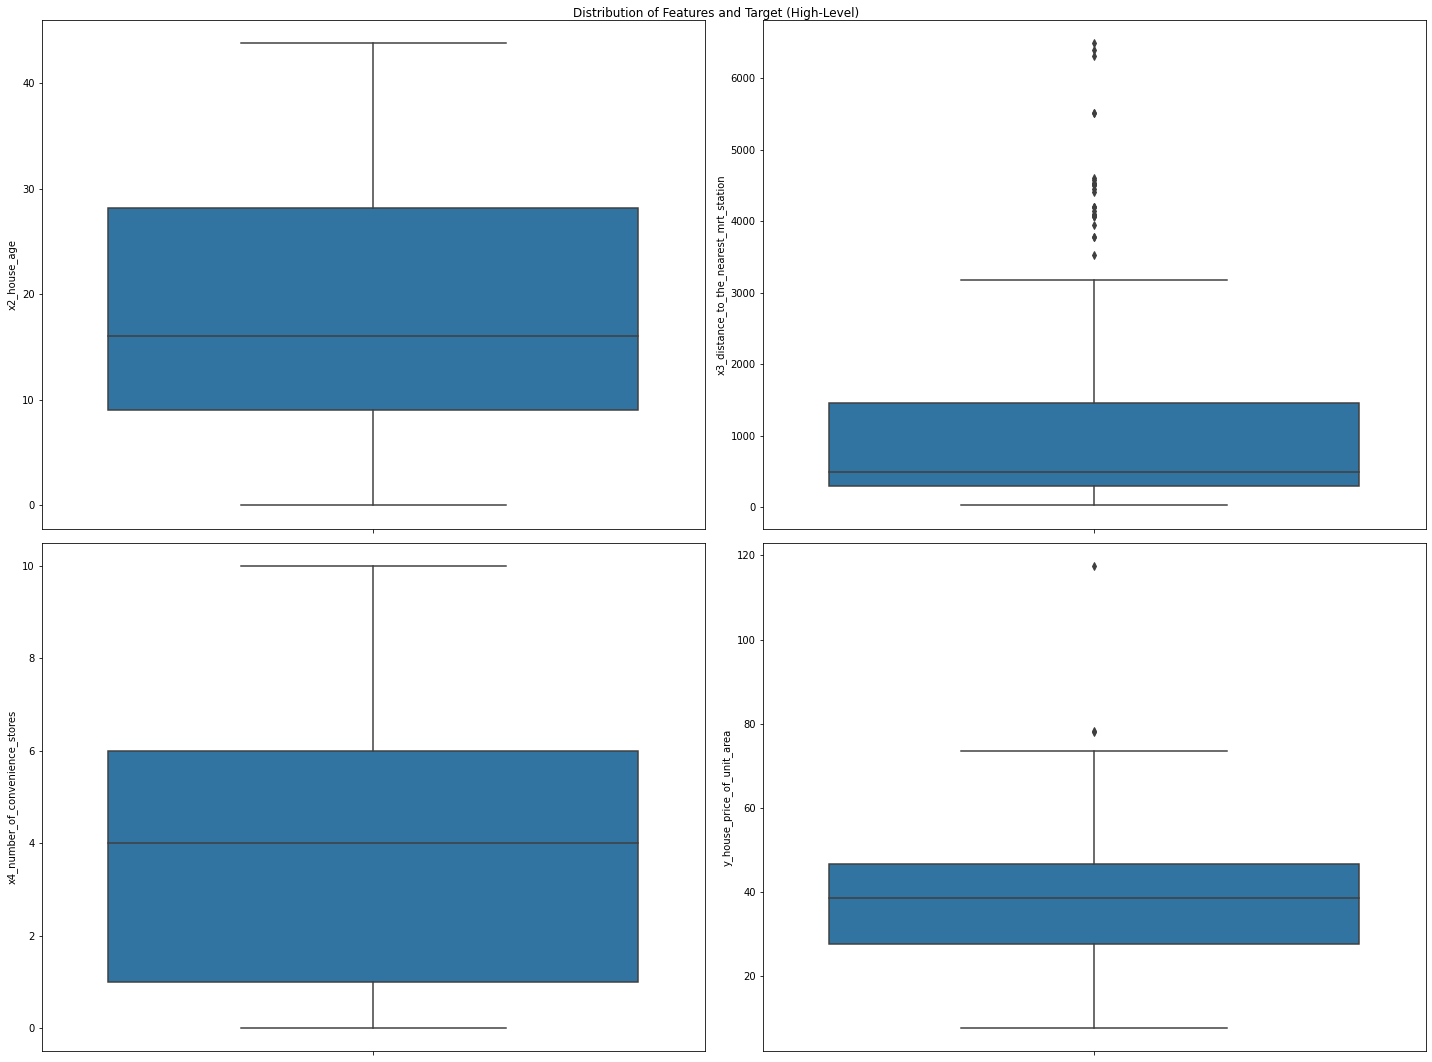

In [23]:
"""plot distribution of features and target"""

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.boxplot(data=real_estate, y='x2_house_age', ax=ax[0,0])
sns.boxplot(data=real_estate, y='x3_distance_to_the_nearest_mrt_station', ax=ax[0, 1])
sns.boxplot(data=real_estate, y='x4_number_of_convenience_stores', ax=ax[1, 0])
sns.boxplot(data=real_estate, y='y_house_price_of_unit_area', ax=ax[1, 1])

fig.suptitle('Distribution of Features and Target (High-Level)')
plt.tight_layout()

Preprocessing

In [24]:
"""split data into training and test"""

X_train, X_test, y_train, y_test = train_test_split(real_estate.iloc[:,:-1], real_estate.iloc[:, -1:],
                                                    test_size=0.30, random_state=14)

In [25]:
"""scale input features"""

#instantiate scaler
mms = MinMaxScaler()
# transform training and test sets
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

### a)	Construct a linear regression model using ordinary least squares method by applying the .LinearRegression() constructor in sklearn and find the training and test accuracy of this model using mean square error (mse). https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [26]:
"""implement sklearn LinearRegression estimator"""

# instantiate and fit the model
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [27]:
"""make predictions on the training set"""

# make predictions
y_pred_train = ols.predict(X_train)
# get mse
mse = mean_squared_error(y_train, y_pred_train, squared=True)
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 86.1359


In [28]:
"""make predictions on the test set"""

# make predictions
y_pred_test = ols.predict(X_test)
# get mse
mse = mean_squared_error(y_test, y_pred_test, squared=True)
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 82.2130


### b)	Check for overfitting. Is there overfitting? Support your answer with some results you generated. 

In [29]:
"""perform cross-validation on the training set to assess model fit"""

# perform crosss-validation on the training set
train_cross_val_pred = cross_val_predict(ols, X_train, y_train, cv=10)
# get rmse
rmse = mean_squared_error(y_train, train_cross_val_pred, squared=False)
# get mse
mse = mean_squared_error(y_train, train_cross_val_pred, squared=True)
# get r2
r2 = r2_score(y_train, train_cross_val_pred)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error: {:.4f}".format(rmse))
print("R-squared: {:.4f}".format(r2))

Mean Squared Error: 90.3869
Root Mean Squared Error: 9.5072
R-squared: 0.5095


In [30]:
"""make predictions on the test set"""

# make predictions
y_pred_test = ols.predict(X_test)
# get rmse
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
# get mse
mse = mean_squared_error(y_test, y_pred_test, squared=True)
# get r2
r2 = r2_score(y_test, y_pred_test)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error: {:.4f}".format(rmse))
print("R-squared: {:.4f}".format(r2))

Mean Squared Error: 82.2130
Root Mean Squared Error: 9.0671
R-squared: 0.5552


The model does not appear to be overfitting to the training set. Model performance actually increased when making predictions on the test set.

### c)	Fit a lasso regression on the data and check the training and test accuracy of the model using mse. Use the default alpha or penalty constant. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [31]:
"""fit a Lasso estimator to the data using default parameters"""

lr = Lasso()
lr.fit(X_train, y_train)

Lasso()

In [32]:
"""make predictions on the training set and calculate mse"""

# make predictions
y_train_pred = lr.predict(X_train)
# get mse
mse = mean_squared_error(y_train, y_train_pred, squared=True)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 122.8661


In [33]:
"""make predictions on the test set and calculate mse"""

# make predictions
y_test_pred = lr.predict(X_test)
# get mse
mse = mean_squared_error(y_test, y_test_pred, squared=True)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 119.4369


### d)	Fit a ridge regression on the data and check the training and test accuracy of the model. Use the default alpha or penalty constant. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html 

In [34]:
"""fit a Ridge estimator to the data using the default parameters"""

rr = Ridge()
rr.fit(X_train, y_train)

Ridge()

In [35]:
"""make predictions on the training set and calculate mse"""

# make predictions
y_train_pred = rr.predict(X_train)
# get mse
mse = mean_squared_error(y_train, y_train_pred, squared=True)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 86.5316


In [36]:
"""make predictions on the test set and calculate mse"""

# make predictions
y_test_pred = rr.predict(X_test)
# get mse
mse = mean_squared_error(y_test, y_test_pred, squared=True)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 81.9054


### e)	Which model is better, OLS, Lasso, or Ridge regression? 

Ridge Regression performed best on the real_estate_data. Mean squared error of predictions made on both the training and test sets was the lowest when using the Ridge reression model. This is likely due to the Ridge algorithms ability to limit the effect of outliers.

### d)	Tune the alpha hyperparameters of the lasso and ridge regression using any tuning technique of your choice? What is the best alpha value for the lasso regression and what is the best alpha value for the ridge regression?

In [40]:
"""apply cross validation to tune the Lasso model"""

# instantiate and fit estimator
lassoCV = LassoCV(alphas=[0.5, 1.0, 1.5, 3.0, 5.0], cv=5, random_state=42)
lassoCV.fit(X_train, y_train.to_numpy().flatten())
# print model alpha
lassoCV.alpha_

0.5

In [41]:
"""make predictions on the test set and print results"""

# make predictions
y_pred_test = lassoCV.predict(X_test)
# get rmse
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
# get mse
mse = mean_squared_error(y_test, y_pred_test, squared=True)
# get r2
r2 = r2_score(y_test, y_pred_test)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error: {:.4f}".format(rmse))
print("R-squared: {:.4f}".format(r2))


Mean Squared Error: 90.6381
Root Mean Squared Error: 9.5204
R-squared: 0.5096


In [44]:
"""apply cross validation to tune the Ridge model"""

# instantiate and fit estimator
ridgeCV = RidgeCV(alphas=[0.5, 1.0, 1.5, 3.0, 5.0], cv=5)
ridgeCV.fit(X_train, y_train)
# print model alpha
ridgeCV.alpha_

1.0

In [45]:
"""make predictions on the test set and print results"""

# make predictions
y_pred_test = ridgeCV.predict(X_test)
# get rmse
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
# get mse
mse = mean_squared_error(y_test, y_pred_test, squared=True)
# get r2
r2 = r2_score(y_test, y_pred_test)
# print the results
print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error: {:.4f}".format(rmse))
print("R-squared: {:.4f}".format(r2))


Mean Squared Error: 81.9054
Root Mean Squared Error: 9.0502
R-squared: 0.5569
